## MENGUJI MANUAL PREDICTOR

In [ ]:
import pandas as pd
import os
from sklearn.datasets import make_regression
from noventis.predictor import ManualPredictor

def test_manual_regression():
    """
    Fungsi untuk menguji ManualPredictor pada tugas regresi.
    Menggunakan data sintetis.
    """
    print("🚀 MEMULAI PENGUJIAN: MANUAL PREDICTOR UNTUK REGRESI")
    print("-" * 60)

    # --- 1. Persiapan Data dan Direktori ---
    output_dir = "noventis_output/regression_manual"
    os.makedirs(output_dir, exist_ok=True)
    print(f"Direktori output disiapkan di: {output_dir}")

    # Membuat data regresi sintetis
    X, y = make_regression(n_samples=200, n_features=10, noise=25, random_state=42)
    df_regr = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(10)])
    df_regr['target'] = y
    print("✅ Dataset regresi sintetis berhasil dibuat.")
    print("Data head:")
    print(df_regr.head())
    print("-" * 60)

    # --- 2. Menjalankan Pipeline dengan Satu Model ---
    print("\n--- Menjalankan ManualPredictor (Single Model: XGBoost) ---")
    manual_predictor_single = ManualPredictor(model_name='xgboost', task='regression')

    # Jalankan pipeline
    result_single = manual_predictor_single.run_pipeline(df=df_regr, target_column='target')
    print(f"Model: {result_single['model_name']}, R2-Score: {result_single['metrics']['r2_score']:.4f}")

    # Simpan model
    model_path = os.path.join(output_dir, "best_xgboost_model.pkl")
    manual_predictor_single.save_model(model_path)
    print("-" * 60)

    # --- 3. Menjalankan Pipeline dengan Perbandingan Beberapa Model ---
    print("\n--- Menjalankan ManualPredictor (Multiple Models Comparison) ---")
    manual_predictor_multi = ManualPredictor(
        model_name=['linear_regression', 'random_forest', 'lightgbm'],
        task='regression'
    )
    result_multi = manual_predictor_multi.run_pipeline(df=df_regr, target_column='target')

    print("\n--- Hasil Perbandingan Manual ---")
    best_model_details = result_multi['best_model_details']
    print(f"Model terbaik: {best_model_details['model_name']}, R2-Score: {best_model_details['metrics']['r2_score']:.4f}")
    print("-" * 60)
    
    print("\n🎉 Pengujian Regresi Selesai.")

if __name__ == '__main__':
    test_manual_regression()

## MENGUJI AUTO PREDICTOR

In [ ]:
# examples/test_automl.py

import pandas as pd
import os, sys
from sklearn.datasets import load_iris
from sklearn.preprocessing import OrdinalEncoder

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import dataset_for_examples

from noventis.predictor import NoventisAutoML
from noventis import data_cleaner

def test_automl_classification():
    """
    Fungsi untuk menguji NoventisAutoML pada tugas klasifikasi.
    Menggunakan dataset Iris.
    """

    # ===================================================================
    # CONTOH PENGGUNAAN NoventisAutoML
    # ===================================================================
    # Load data
    df_raw = pd.read_csv('../dataset_for_examples/diamonds.csv') # Atau gunakan DataFrame langsung
    df_raw.columns = df_raw.columns.str.replace(r'[^A-Za-z0-9_]+', '_', regex=True)

    # df = data_cleaner(
    #     data=df_raw,
    #     target_column='cut',
    #     outlier_handling=False,
    # )
    # Automatically select columns of type 'object'
    categorical_cols = df_raw.select_dtypes(include=['object']).columns

    # Create a copy
    df_ordinal = df_raw.copy()

    # Create and apply the encoder
    ordinal_encoder = OrdinalEncoder()
    df_ordinal[categorical_cols] = ordinal_encoder.fit_transform(df_ordinal[categorical_cols])

    # ===================================================================
    # 1. BASIC USAGE - AutoML Sederhana
    # ===================================================================
    # Initialize NoventisAutoML
    
    # automl = NoventisAutoML(
    #     data=df_ordinal,                    # Dataset (CSV path atau DataFrame)
    #     target='cut',     # Nama kolom target
    #     task='classification',      # 'classification' atau 'regression' (optional, auto-detect)
    #     test_size=0.2,             # Proporsi data test
    #     random_state=42            # Random seed untuk reproducibility
    # )

    # # Train model dengan visualisasi
    # results = automl.fit(
    #     time_budget=120,           # Waktu training dalam detik
    #     metric='macro_f1',         # Metrik evaluasi (optional)
    #     explain=True,              # Generate visualisasi dan penjelasan
    #     compare=False,             # Bandingkan dengan model lain
    #     output_dir='results',       # Direktori output
    # )

    # print("🎉 Training selesai!")
    # print(f"Best Model: {results['best_estimator']}")
    # print(f"Metrics: {results['metrics']}")
    
    # ===================================================================
    # 2. ADVANCED USAGE - Dengan Perbandingan Model
    # ===================================================================
    
    # Initialize dengan auto-detection task type
    automl_advanced = NoventisAutoML(
        data=df_ordinal,
        target='cut',            # Untuk regression example
        models=['xgboost', 'lightgbm', 'decision_tree'],
        explain=True,
        compare=True
    )

    # Training dengan perbandingan model
    advanced_results = automl_advanced.fit(
        time_budget=300,           # 5 menit training
        
        # FLAML specific parameters
        # eval_method='cv',          # Cross-validation
        # split_ratio=0.8,          # Train/validation split
        # n_splits=5,               # CV folds
        # ensemble=True             # Enable ensemble
    )

    print("\n📊 Advanced Results:")
    print(f"Best Model: {advanced_results['best_estimator']}")
    print(f"Model Comparison: {advanced_results.get('model_comparison', 'Not available')}")
    
    # ===================================================================
    # 3. MANUAL MODEL COMPARISON
    # ===================================================================
    '''
    # Jika ingin compare model secara terpisah
    comparison_results = automl.compare_models(
        models_to_compare=['logistic_regression', 'random_forest', 'xgboost', 'svm'],
        output_dir='comparison_results'
    )

    print("\n🏆 Model Rankings:")
    for i, model_info in enumerate(comparison_results['rankings'], 1):
        print(f"{i}. {model_info['model']}: {model_info['score']:.4f}")

    # ===================================================================
    # 4. PREDIKSI DENGAN MODEL YANG SUDAH DILATIH
    # ===================================================================

    # Data baru untuk prediksi
    new_data = df.drop('cut', axis=1)  # Tanpa kolom target

    # Prediksi menggunakan model yang sudah dilatih
    predictions = automl.predict(new_data)
    print("\n🔮 Prediksi baru:")
    print(predictions['predictions'][:10])  # Show first 10 predictions

    # Jika classification, akan ada probabilitas
    if 'probabilities' in predictions:
        print("Probabilitas:")
        print(predictions['probabilities'][:5])

    # ===================================================================
    # 5. LOAD MODEL DARI FILE
    # ===================================================================

    # Load saved model
    saved_model = automl.load_model('results/best_automl_model.pkl')

    # Prediksi dengan loaded model
    predictions_from_saved = automl.predict(new_data, model_path='results/best_automl_model.pkl')

    # ===================================================================
    # 6. EXPORT HASIL KE CSV
    # ===================================================================

    # Export semua hasil ke CSV
    automl.export_results_to_csv(output_dir='exported_results')

    # ===================================================================
    # 7. GET MODEL INFORMATION
    # ===================================================================

    # Dapatkan info detail model
    model_info = automl.get_model_info()
    print("\n📋 Model Information:")
    for key, value in model_info.items():
        print(f"{key}: {value}")

    # ===================================================================
    # 8. HYPERPARAMETER SUGGESTIONS
    # ===================================================================

    # Dapatkan saran hyperparameter untuk model terbaik
    hp_suggestions = automl.get_hyperparameter_suggestions()
    print("\n⚙️ Hyperparameter Suggestions:")
    print(hp_suggestions)

    # ===================================================================
    # 9. CUSTOM CONFIGURATION EXAMPLES
    # ===================================================================

    # Classification dengan konfigurasi khusus
    classification_automl = NoventisAutoML(
        data=df,
        target='category',
        task='classification'
    )

    classification_results = classification_automl.fit(
        time_budget=180,
        metric='roc_auc',
        explain=True,
        compare=True,
        
        # FLAML Advanced Settings
        estimator_list=['lgbm', 'xgboost', 'catboost'],
        log_training_metric=True,
        verbose=1,
        retrain_full=True,
        split_type='stratified',
        hpo_method='cfo',          # Hyperparameter optimization method
        starting_points='data'      # Starting points for HPO
    )

    # Regression dengan konfigurasi khusus
    regression_automl = NoventisAutoML(
        data='house_prices.csv',
        target='price',
        task='regression'
    )

    regression_results = regression_automl.fit(
        time_budget=240,
        metric='rmse',
        explain=True,
        compare=True,
        
        # Custom settings
        estimator_list=['lgbm', 'xgboost', 'rf', 'extra_tree'],
        ensemble=True,
        max_iter=100,
        early_stop=True,
        split_ratio=0.75
    )

    # ===================================================================
    # 10. ERROR HANDLING EXAMPLE
    # ===================================================================

    try:
        # Initialize dengan data yang mungkin bermasalah
        problematic_automl = NoventisAutoML(
            data='might_not_exist.csv',
            target='target'
        )
        
        results = problematic_automl.fit(
            time_budget=60,
            explain=True,
            compare=True
        )
        
    except FileNotFoundError:
        print("❌ File dataset tidak ditemukan!")
        
    except ValueError as e:
        print(f"❌ Error dalam konfigurasi: {e}")
        
    except Exception as e:
        print(f"❌ Unexpected error: {e}")

    # ===================================================================
    # 11. BATCH PROCESSING EXAMPLE
    # ===================================================================

    # Process multiple datasets
    datasets = ['dataset1.csv', 'dataset2.csv', 'dataset3.csv']
    targets = ['target1', 'target2', 'target3']

    batch_results = {}

    for dataset, target in zip(datasets, targets):
        try:
            print(f"\n🔄 Processing {dataset}...")
            
            automl_batch = NoventisAutoML(
                data=dataset,
                target=target
            )
            
            result = automl_batch.fit(
                time_budget=120,
                explain=True,
                compare=False,
                output_dir=f'batch_results/{dataset.split(".")[0]}'
            )
            
            batch_results[dataset] = {
                'best_model': result['best_estimator'],
                'performance': result['metrics'],
                'success': True
            }
            
        except Exception as e:
            print(f"❌ Error processing {dataset}: {e}")
            batch_results[dataset] = {'success': False, 'error': str(e)}

    # Print batch results summary
    print("\n📊 Batch Processing Summary:")
    for dataset, result in batch_results.items():
        if result['success']:
            print(f"✅ {dataset}: {result['best_model']} - {result['performance']}")
        else:
            print(f"❌ {dataset}: Failed - {result['error']}")

    # ===================================================================
    # 12. REAL-TIME MONITORING EXAMPLE
    # ===================================================================

    import time
    from datetime import datetime

    class AutoMLMonitor:
        def __init__(self):
            self.start_time = None
            self.results = []
        
        def run_automl_with_monitoring(self, data, target, time_budget=300):
            self.start_time = datetime.now()
            print(f"🚀 Starting AutoML at {self.start_time}")
            
            automl = NoventisAutoML(data=data, target=target)
            
            # Custom callback untuk monitoring (jika FLAML support)
            results = automl.fit(
                time_budget=time_budget,
                explain=True,
                compare=True,
                verbose=1
            )
            
            end_time = datetime.now()
            duration = (end_time - self.start_time).total_seconds()
            
            self.results.append({
                'start_time': self.start_time,
                'end_time': end_time,
                'duration': duration,
                'best_model': results['best_estimator'],
                'performance': results['metrics']
            })
            
            print(f"✅ AutoML completed in {duration:.2f} seconds")
            return results

    # Usage
    monitor = AutoMLMonitor()
    monitored_results = monitor.run_automl_with_monitoring(
        data='large_dataset.csv',
        target='target_column',
        time_budget=600  # 10 minutes
    )

    print("\n📈 Monitoring Results:")
    print(f"Total Duration: {monitor.results[-1]['duration']:.2f} seconds")
    print(f"Best Model: {monitor.results[-1]['best_model']}")
    '''
    # ===================================================================
    # OUTPUT FILES YANG DIHASILKAN:
    # ===================================================================
    """
    Setelah menjalankan NoventisAutoML dengan explain=True, 
    file-file berikut akan dibuat di output directory:

    📁 output_directory/
    ├── 📊 feature_importance.png          # Feature importance plot
    ├── 📈 training_history.png           # Training progress curve
    ├── 🔍 confusion_matrix.png           # Confusion matrix (classification)
    ├── 📊 classification_metrics.png     # Classification metrics bar plot
    ├── 📈 predictions_vs_actual.png      # Pred vs actual (regression)
    ├── 📊 residuals_plot.png            # Residuals plot (regression)
    ├── 📊 regression_metrics.png        # Regression metrics bar plot
    ├── 📊 model_comparison.png          # Model comparison (jika compare=True)
    ├── 🌡️ metrics_heatmap.png           # Metrics heatmap across models
    ├── 💾 best_automl_model.pkl         # Saved best model
    ├── 📄 model_summary.txt             # Model summary report
    ├── 📄 model_comparison_report.txt   # Comparison report (jika compare=True)
    ├── 📄 flaml.log                     # FLAML training log
    ├── 📊 predictions.csv               # Predictions hasil
    ├── 📊 metrics.csv                   # Metrics hasil
    └── 📊 feature_importance.csv        # Feature importance data
    """

if __name__ == '__main__':
    test_automl_classification()

c:\Users\LENOVO\anaconda3\envs\env3.12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Data berhasil dimuat dari DataFrame
📊 Shape data: (53940, 11)
📋 Kolom: ['Unnamed_0', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']
✅ Tipe tugas terdeteksi: classification
✅ Data berhasil dibagi: Train=43152, Test=10788
📈 Target distribution: {2.0: 21551, 3.0: 13791, 4.0: 12082, 1.0: 4906, 0.0: 1610}


TypeError: NoventisAutoML.fit() got an unexpected keyword argument 'explain'

In [ ]:
df_raw

NameError: name 'automl_advanced' is not defined

INFO:root:Running pipeline for single model: random_forest
INFO:root:--- Processing model: RANDOM_FOREST ---


🧪 Testing ManualPredictor...

1️⃣ Testing Classification...


INFO:root:Training completed in 0.30 seconds.



📊 MODEL COMPARISON - ALL METRICS
Model                Accuracy     Precision    Recall       F1-Score    
--------------------------------------------------------------------
random_forest        0.9600       0.9603       0.9600       0.9600      


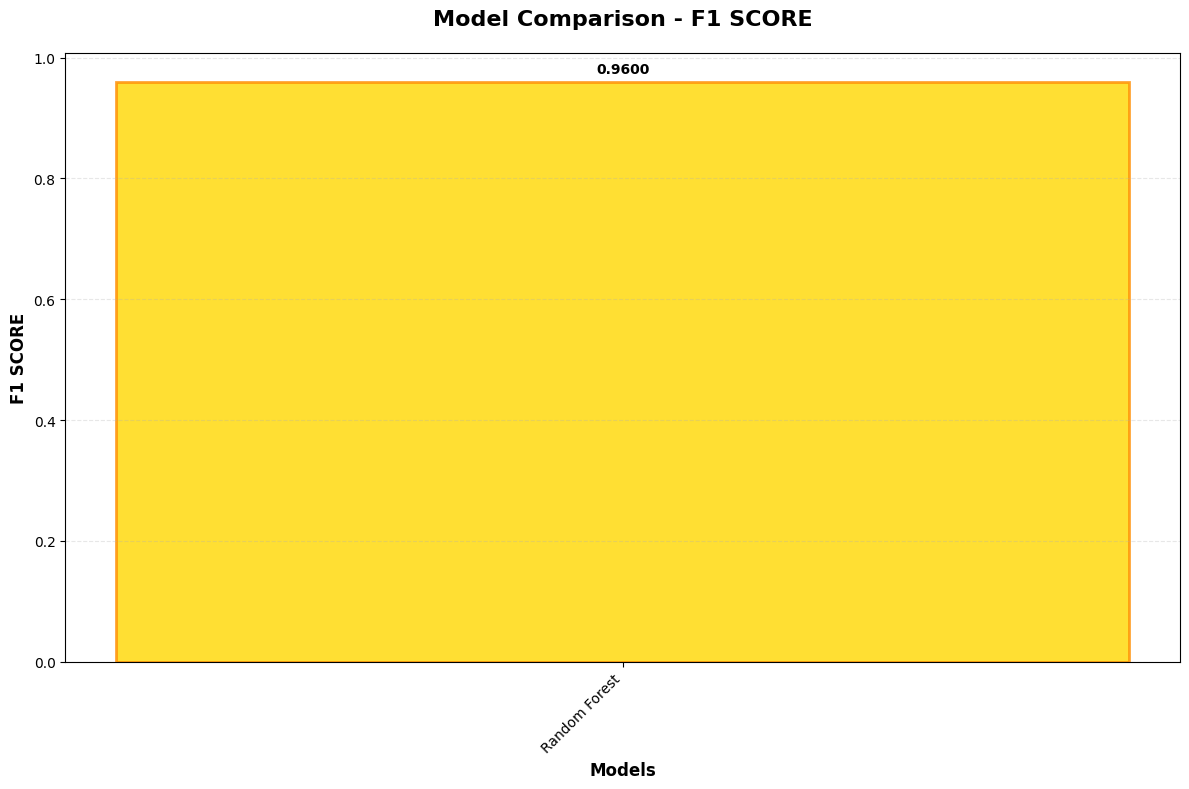

INFO:root:Starting multi-model comparison and ensembling mode.
INFO:root:--- Processing model: RANDOM_FOREST ---
INFO:root:Training completed in 0.20 seconds.
INFO:root:--- Processing model: XGBOOST ---
INFO:root:Training completed in 0.19 seconds.
INFO:root:--- Processing model: LIGHTGBM ---
INFO:root:Training completed in 0.07 seconds.
INFO:root:--- Processing model: ENSEMBLE ---
INFO:root:Ensemble training completed in 0.34 seconds.
INFO:root:
--- Comparison Complete ---
INFO:root:🏆 Best Model: XGBOOST with f1_score = 0.9700



📊 MODEL COMPARISON - ALL METRICS
Model                Accuracy     Precision    Recall       F1-Score    
--------------------------------------------------------------------
random_forest        0.9600       0.9603       0.9600       0.9600      
xgboost              0.9700       0.9708       0.9700       0.9700      
lightgbm             0.9600       0.9606       0.9600       0.9601      
ensemble             0.9500       0.9511       0.9500       0.9501      


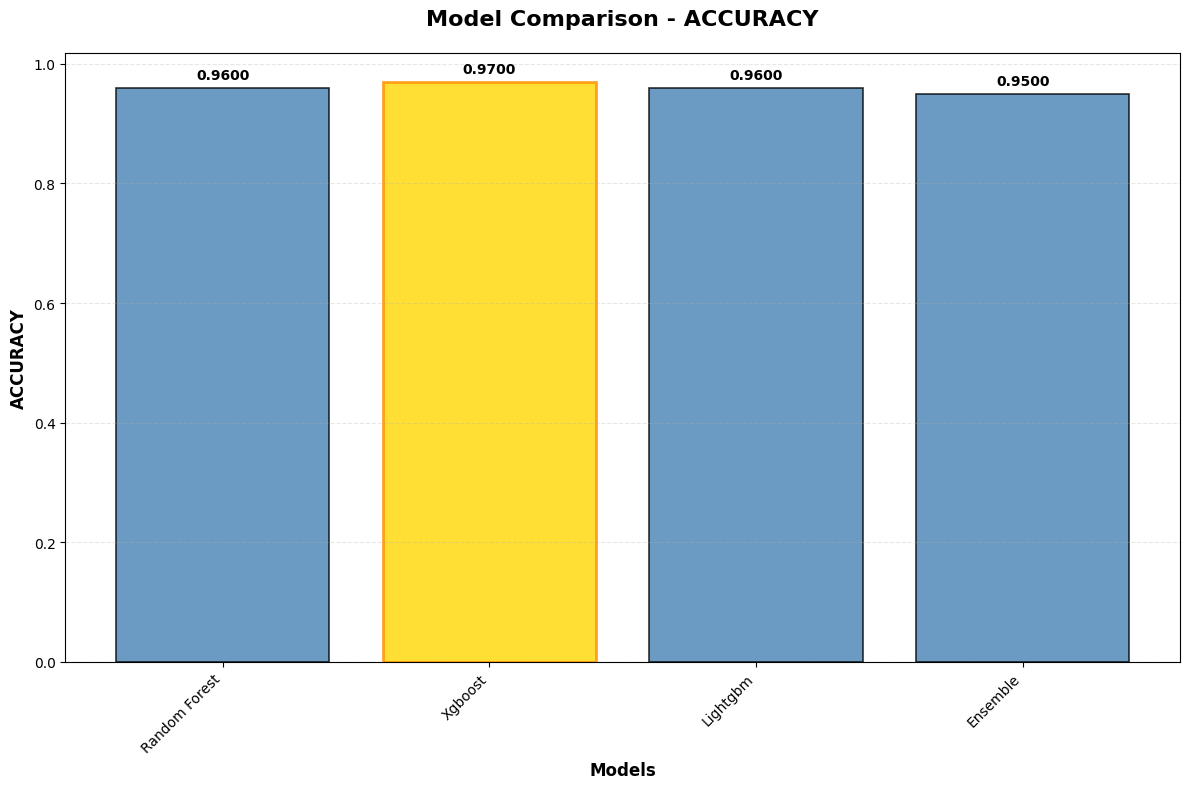

INFO:root:Starting multi-model comparison and ensembling mode.
INFO:root:--- Processing model: RANDOM_FOREST ---



2️⃣ Testing Regression...


INFO:root:Training completed in 0.36 seconds.
INFO:root:--- Processing model: XGBOOST ---
INFO:root:Training completed in 0.18 seconds.
INFO:root:--- Processing model: GRADIENT_BOOSTING ---
INFO:root:Training completed in 0.24 seconds.
INFO:root:--- Processing model: ENSEMBLE ---
INFO:root:Ensemble training completed in 0.61 seconds.
INFO:root:
--- Comparison Complete ---
INFO:root:🏆 Best Model: GRADIENT_BOOSTING with r2_score = 0.8729



📊 MODEL COMPARISON - ALL METRICS
Model                MAE          MSE          RMSE         R2-Score    
--------------------------------------------------------------------
random_forest        50.1237      4047.3223    63.6186      0.8054      
xgboost              45.9344      3618.4188    60.1533      0.8261      
gradient_boosting    40.3764      2644.2542    51.4223      0.8729      
ensemble             42.2940      2933.7608    54.1642      0.8590      


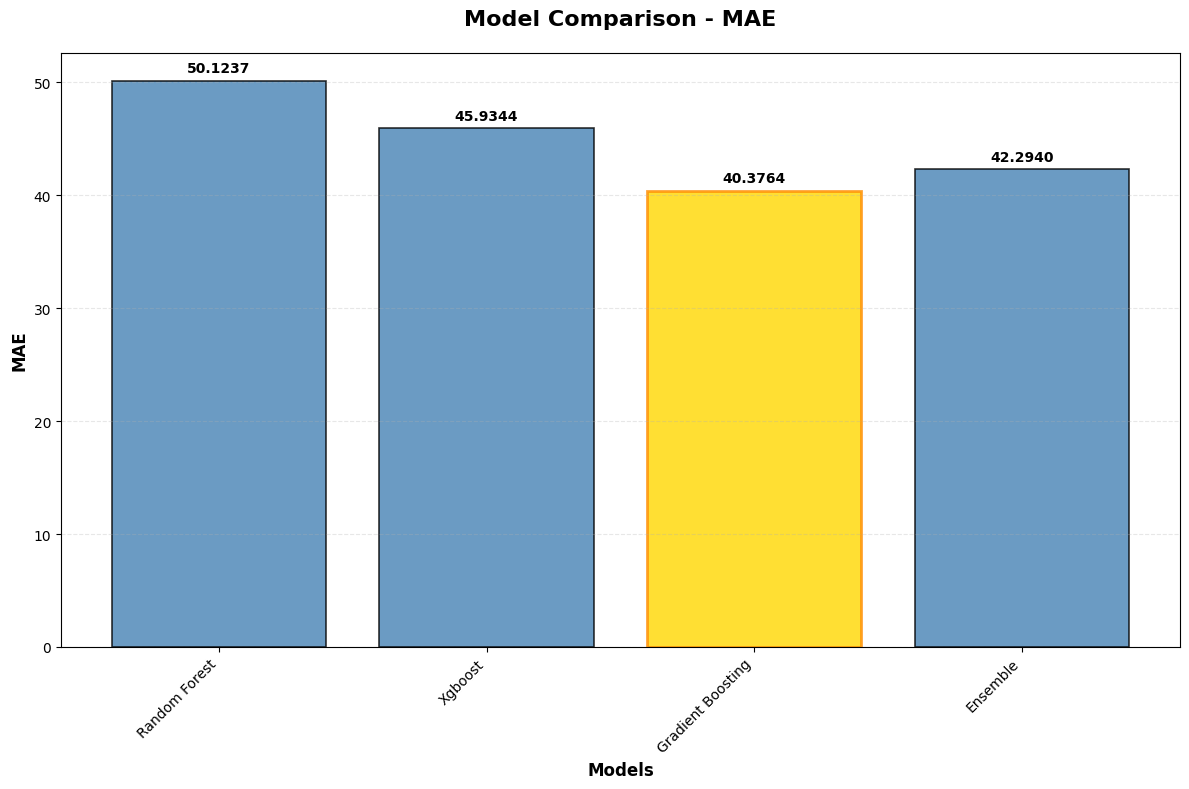

INFO:root:Saving best model 'gradient_boosting' to test_model.pkl...
INFO:root:✅ Model saved successfully.
INFO:root:Loading model from test_model.pkl...
INFO:root:✅ Model loaded successfully.



3️⃣ Testing Save/Load...

✅ All tests completed successfully!


In [2]:
# Tes 3

# =====================================================================
# CONCISE TEST CODE
# =====================================================================

import pandas as pd
import os
from sklearn.datasets import make_regression
from noventis.predictor import ManualPredictor

def quick_test():
    """Quick test function for ManualPredictor class."""
    
    # Generate sample data
    from sklearn.datasets import make_classification, make_regression
    
    print("🧪 Testing ManualPredictor...")
    
    # Test 1: Classification
    print("\n1️⃣ Testing Classification...")
    X_clf, y_clf = make_classification(
    n_samples=500,
    n_features=10,
    n_clusters_per_class=1, 
    n_classes=3,
    random_state=42
)
    df_clf = pd.DataFrame(X_clf, columns=[f'feature_{i}' for i in range(10)])
    df_clf['target'] = y_clf
    
    # Single model test
    predictor_single = ManualPredictor('random_forest', 'classification')
    result_single = predictor_single.run_pipeline(df_clf, 'target', compare=True, explain=True)
    
    # Multiple models test
    predictor_multi = ManualPredictor(['random_forest', 'xgboost', 'lightgbm'], 'classification')
    result_multi = predictor_multi.run_pipeline(df_clf, 'target', compare=True, explain=True, chosen_metric='accuracy')
    
    # Test 2: Regression
    print("\n2️⃣ Testing Regression...")
    X_reg, y_reg = make_regression(n_samples=500, n_features=10, random_state=42)
    df_reg = pd.DataFrame(X_reg, columns=[f'feature_{i}' for i in range(10)])
    df_reg['target'] = y_reg
    
    # Multiple models test for regression
    predictor_reg = ManualPredictor(['random_forest', 'xgboost', 'gradient_boosting'], 'regression')
    result_reg = predictor_reg.run_pipeline(df_reg, 'target', compare=True, explain=True, chosen_metric='mae')
    
    # Test 3: Save and Load Model
    print("\n3️⃣ Testing Save/Load...")
    predictor_reg.save_model('test_model.pkl')
    loaded_model = ManualPredictor.load_model('test_model.pkl')
    
    print("\n✅ All tests completed successfully!")
    return result_single, result_multi, result_reg

if __name__ == "__main__":
    # Run the quick test
    single_result, multi_result, reg_result = quick_test()